# Visualize the MS-SMC' likelihood surface

In [1]:
from pathlib import Path
import toytree
import ipcoal
import pandas as pd
import numpy as np
from scipy import stats

In [2]:
import matplotlib.pyplot as plt
from matplotlib import ticker
plt.rcParams['figure.figsize'] = [4, 3]

In [3]:
from numba import set_num_threads
set_num_threads(60)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [4]:
print(toytree.__version__)
print(ipcoal.__version__)

3.0.dev8
0.4.dev3


In [6]:
# ! rm -r ../manuscript/figures/likelihood-heatmaps/
DIR = Path("../manuscript/figures/likelihood-heatmaps")
DIR.mkdir(exist_ok=True)

## Parameters

In [7]:
RECOMB = 2e-9
SEED = 123
NEFFS = {0: 2e5, 1: 3e5, 2: 4e5}
ROOT_HEIGHT = 5e5
NSPECIES = 2
NSAMPLES = 4

NSITES = 1e5
NLOCI = 50

In [8]:
NEFF_MIN = 5e4
R_MIN = 1e-9
NEFF_MAX = 9.5e5
R_MAX = 3e-9
N_VALUES = 31

## Simulate ARGs on a 2-population model

In [11]:
sptree = toytree.rtree.imbtree(NSPECIES, treeheight=ROOT_HEIGHT)
sptree = sptree.set_node_data("Ne", NEFFS)

In [12]:
# get a parameterized ipcoal Model
model = ipcoal.Model(
    sptree,
    nsamples=NSAMPLES,
    recomb=RECOMB,
    seed_trees=SEED,
    discrete_genome=False,
    record_full_arg=True,
    ancestry_model="hudson",
)

In [13]:
# get mapping of samples to species
imap = model.get_imap_dict()

### Get trees and interval lengths from tree sequences

In [14]:
# data to fill
trees_r = []
trees_g = []
trees_t = []
dists_r = []
dists_g = []
dists_t = []
events = []

# iterate over each tree sequence
for lidx in range(NLOCI):
    
    # get full tree sequence and store first tree
    ts = next(model._get_tree_sequence_generator(nsites=NSITES))
    tree = ts.first(sample_lists=True)
    
    # get a simplified tree sequence and store first simplified tree
    sts = ts.simplify(filter_sites=False)
    stree = sts.at(tree.interval.left, sample_lists=True)
    last_tree = stree.copy()
    last_topo = stree.copy()
    
    # distance counters start w/ length of first interval
    sum_tree_dist = tree.get_length()
    sum_topo_dist = tree.get_length()
    
    # store first tree
    trees_r.append(stree.copy())
    dists_r.append(tree.get_length())
        
    # advance to next tree in the full tree sequence
    while tree.next():
   
        # get simple tree in next interval (at tree's position in sts)
        stree = sts.at(tree.interval.left, sample_lists=True)
        
        # store this event
        trees_r.append(stree.copy())
        dists_r.append(tree.get_length())
        
        # if tree changed
        if stree.kc_distance(last_tree, lambda_=1):
            
            # if topology changed
            if stree.kc_distance(last_topo, lambda_=0):
                trees_t.append(last_topo.copy())
                dists_t.append(sum_topo_dist)
                trees_g.append(last_tree.copy())
                dists_g.append(sum_tree_dist)
                last_topo = stree.copy()
                last_tree = stree.copy()
                events.append(2)
                sum_tree_dist = tree.get_length()
                sum_topo_dist = tree.get_length()
                
            # only branch length changed
            else:
                trees_g.append(last_tree.copy())
                dists_g.append(sum_tree_dist)
                last_tree = stree.copy()
                events.append(1)
                sum_tree_dist = tree.get_length()
                sum_topo_dist += tree.get_length()

        # no change occured
        else:
            events.append(0)
            sum_tree_dist += tree.get_length()
            sum_topo_dist += tree.get_length()

# convert interval lengths to arrays
dists_r = np.array(dists_r)
dists_g = np.array(dists_g)
dists_t = np.array(dists_t)
events = np.array(events)

# convert all tskit trees to ToyTrees
trees_r = [toytree.tree(i.as_newick(node_labels=model.tipdict)) for i in trees_r]
trees_g = [toytree.tree(i.as_newick(node_labels=model.tipdict)) for i in trees_g]
trees_t = [toytree.tree(i.as_newick(node_labels=model.tipdict)) for i in trees_t]

### Summarize simulated ARG and recomb event types

In [15]:
print(f"{len(trees_r)} R (recomb) intervals w/ average length={dists_r.mean():.2f}")
print(f"{len(trees_g)} G (tree-change) intervals w/ average length={dists_g.mean():.2f}")
print(f"{len(trees_t)} T (topo-change) intervals w/ average length={dists_t.mean():.2f}")

50848 R (recomb) intervals w/ average length=98.33
37771 G (tree-change) intervals w/ average length=132.18
17671 T (topo-change) intervals w/ average length=281.88


In [33]:
# multitree drawing kwargs
kwargs = dict(
    shape=(1, 6), 
    width=900, 
    height=300,
    edge_type='p',
    layout='d',
    fixed_order=trees_r[0].get_tip_labels(), 
    shared_axes=True, 
    scale_bar=True, 
)

In [34]:
# trees between any recomb event [r]
toytree.mtree(trees_r[:6]).draw(**kwargs);

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="900.0px" height="300.0px" viewBox="0 0 900.0 300.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="td6e4dd53b16d4fab83aa46c3fddc9460"> r0_1 r0_2 r0_3 r1_2 r1_1 r1_3 r0_0 r1_0 0 1000000 2000000 3000000 r0_0 r1_0 r0_1 r0_2 r0_3 r1_2 r1_1 r1_3 0 1000000 2000000 3000000 r0_0 r1_0 r0_1 r0_2 r0_3 r1_2 r1_1 r1_3 0 1000000 2000000 3000000 r0_0 r1_0 r0_1 r0_2 r0_3 r1_2 r1_1 r1_3 0 1000000 2000000 3000000 r0_1 r0_2 r0_3 r1_2 r1_1 r1_3 r0_0 r1_0 0 1000000 2000000 3000000 r0_1 r0_2 r0_3 r1_2 r1_1 r1_3 r0_0 r1_0 0 1000000 2000000 3000000

In [35]:
# trees between tree-change events [g]
toytree.mtree(trees_g[:8]).draw(**kwargs);

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="900.0px" height="300.0px" viewBox="0 0 900.0 300.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="tcd6d61c0c6bc48939a98719734e694ed"> r0_1 r0_2 r0_3 r1_2 r1_1 r1_3 r0_0 r1_0 0 1000000 2000000 3000000 r0_0 r1_0 r0_1 r0_2 r0_3 r1_2 r1_1 r1_3 0 1000000 2000000 3000000 r0_0 r1_0 r0_1 r0_2 r0_3 r1_2 r1_1 r1_3 0 1000000 2000000 3000000 r0_1 r0_2 r0_3 r1_2 r1_1 r1_3 r0_0 r1_0 0 1000000 2000000 3000000 r0_1 r0_2 r0_3 r1_2 r1_1 r1_3 r0_0 r1_0 0 1000000 2000000 3000000 r0_1 r0_2 r0_3 r1_2 r1_1 r1_3 r0_0 r1_0 0 1000000 2000000 3000000

In [36]:
toytree.mtree(trees_t[:8]).draw(**kwargs);

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="900.0px" height="300.0px" viewBox="0 0 900.0 300.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="tc143df8d1ec947978de47ee1505a31e9"> r0_1 r0_2 r0_3 r1_2 r1_1 r1_3 r0_0 r1_0 0 1000000 2000000 3000000 r0_0 r1_0 r0_1 r0_2 r0_3 r1_2 r1_1 r1_3 0 1000000 2000000 3000000 r0_1 r0_2 r0_3 r1_2 r1_1 r1_3 r0_0 r1_0 0 1000000 2000000 3000000 r0_1 r0_2 r0_3 r0_0 r1_0 r1_2 r1_1 r1_3 0 1000000 2000000 3000000 r1_0 r1_2 r1_1 r1_3 r0_0 r0_1 r0_2 r0_3 0 1000000 2000000 3000000 r1_2 r1_1 r1_3 r0_0 r0_1 r0_2 r0_3 r1_0 0 1000000 2000000 3000000

### Get embedding tables
These are functions from ipcoal for fast likelihood calculations

In [37]:
from ipcoal.msc import _get_msc_loglik_from_embedding
from ipcoal.smc.src.embedding import TreeEmbedding
from ipcoal.smc.src.ms_smc_tree_prob import get_fast_tree_changed_lambdas
from ipcoal.smc.src.ms_smc_topo_prob import get_fast_topo_changed_lambdas
from ipcoal.smc.src.likelihood import get_waiting_distance_loglik, _update_neffs

In [38]:
R = TreeEmbedding(model.tree, trees_r, imap, nproc=20)

In [39]:
G = TreeEmbedding(model.tree, trees_g, imap, nproc=20)

In [40]:
T = TreeEmbedding(model.tree, trees_t, imap, nproc=20)

### Test likelihood methods

#### SMC

In [41]:
get_waiting_distance_loglik(R, RECOMB, dists_r, event_type=0)

280755.37713235494

In [42]:
get_waiting_distance_loglik(G, RECOMB, dists_g, event_type=1)

220393.27117641785

In [43]:
get_waiting_distance_loglik(T, RECOMB, dists_t, event_type=2)

116233.19716651915

#### MSC

In [44]:
_get_msc_loglik_from_embedding(R.emb)

5123686.719247847

In [45]:
_get_msc_loglik_from_embedding(G.emb)

3803974.680352148

In [46]:
_get_msc_loglik_from_embedding(T.emb)

1782918.8111907977

### GRID
These are the ranges of parameters over which we will examine the likelihood surface.

In [47]:
def get_smc_likelihood_surface_Nx_r(
    embedding: TreeEmbedding,
    lengths: np.ndarray,
    event_type: int,
    nidx: int = 0,
    min_neff: int = 10_000,
    max_neff: int = 400_000,
    min_recomb: float = 0.1e-9,
    max_recomb: float = 10e-9,
    n_values: int = 21,
):
    """Return an array of log likelihood scores over a grid of parameters.
    
    """
    neffs = np.linspace(min_neff, max_neff, n_values)
    recos = np.linspace(min_recomb, max_recomb, n_values)
    X, Y = np.meshgrid(neffs, recos, indexing="ij")
    Z = np.zeros(X.shape)

    for i, n0 in enumerate(neffs):
        
        # update the 2 * diploid Ne values in the Embedding table and get loglik
        params = np.array([NEFFS[i] for i in sorted(NEFFS)])
        params[nidx] = n0
        _update_neffs(embedding.emb, params)
        for j, rec in enumerate(recos):
            Z[i, j] = get_waiting_distance_loglik(embedding, rec, lengths, event_type=event_type)
    return X, Y, Z

In [48]:
def get_msc_likelihood_surface_Nx_r(
    embedding: ipcoal.smc.likelihood.Embedding,
    nidx: int = 0,
    min_neff: int = 10_000,
    max_neff: int = 400_000,
    min_recomb: float = 0.1e-9,
    max_recomb: float = 10e-9,
    n_values: int=21,
    #n_recomb_values: int=11,
):
    """Return an array of log likelihood scores for a grid of parameters.
    
    """
    neffs = np.linspace(min_neff, max_neff, n_values)
    recos = np.linspace(min_recomb, max_recomb, n_values)
    X, Y = np.meshgrid(neffs, recos, indexing="ij")
    Z = np.zeros(X.shape)

    for i, n0 in enumerate(neffs):

        # update the embedding table with 2Ne
        params = np.array([NEFFS[i] for i in sorted(NEFFS)])
        params[nidx] = n0
        _update_neffs(embedding.emb, params)

        # get expon rate parameter for each embedded genealogy
        Z[i, :] = _get_msc_loglik_from_embedding(embedding.emb)
            
    return X, Y, Z

In [49]:
def get_smc_likelihood_surface_Nx_Ny(
    embedding: ipcoal.smc.likelihood.Embedding,
    lengths: np.ndarray,
    event_type: int,
    nidx: int = 0,
    nidy: int = 1,
    min_neff: int = 10_000,
    max_neff: int = 400_000,
    n_values: int=21,
    #n_recomb_values: int=11,
):
    """Return an array of log likelihood scores for a grid of parameters.
    
    """
    neffs0 = np.linspace(min_neff, max_neff, n_values)
    neffs1 = np.linspace(min_neff, max_neff, n_values)
    X, Y = np.meshgrid(neffs0, neffs1, indexing="ij")
    Z = np.zeros(X.shape)
       
    for i, n0 in enumerate(neffs0):
        for j, n1 in enumerate(neffs1):
            
            # update the embedding table with 2Ne
            params = np.array([NEFFS[i] for i in sorted(NEFFS)])
            params[nidx] = n0
            params[nidy] = n1
            _update_neffs(embedding.emb, params)

            # get expon rate parameter for each embedded genealogy
            Z[i, j] = get_waiting_distance_loglik(embedding, RECOMB, lengths, event_type=event_type)
    return X, Y, Z

In [50]:
def get_msc_likelihood_surface_Nx_Ny(
    embedding: ipcoal.smc.likelihood.Embedding,
    nidx: int = 0,
    nidy: int = 1,
    min_neff: int = 10_000,
    max_neff: int = 400_000,
    min_recomb: float = 0.1e-9,
    max_recomb: float = 10e-9,
    n_values: int=21,
    #n_recomb_values: int=11,
):
    """Return an array of log likelihood scores for a grid of parameters.
    """
    neffs0 = np.linspace(min_neff, max_neff, n_values)
    neffs1 = np.linspace(min_neff, max_neff, n_values)
    X, Y = np.meshgrid(neffs0, neffs1, indexing="ij")
    Z = np.zeros(X.shape)
       
    for i, n0 in enumerate(neffs0):
        for j, n1 in enumerate(neffs1):
            
            # update the embedding table with 2Ne
            params = np.array([NEFFS[i] for i in sorted(NEFFS)])
            params[nidx] = n0
            params[nidy] = n1
            _update_neffs(embedding.emb, params)

            # get expon rate parameter for each embedded genealogy
            Z[i, j] = _get_msc_loglik_from_embedding(embedding.emb)

    return X, Y, Z

In [51]:
def plot_likelihood_surface_Nx_Ny(x, y, z, nidx=0, nidy=1, levels=30, title="", vmin=None):
    # setup axes
    fig, ax = plt.subplots()
    
    # contour and x marks
    vmin = -z.max() + (z.max() - z.min()) / 2
    cs = ax.contourf(x, y, -z, levels=levels, cmap='viridis', linestyles='solid', vmin=vmin)
    ma = ax.scatter(NEFFS[nidx], NEFFS[nidy], marker="x", s=75, linewidth=2, color="black")
    
    # colorbar
    cbar = fig.colorbar(cs)
    cbar.ax.set_ylabel("log likelihood", fontsize=12)
    if z.min() == z.max():
        cbar.locator = ticker.NullLocator()
    cbar.formatter.set_powerlimits((3, 3))

    # style xy axes
    ax.set_xlabel(f'Diploid N$_e${nidx}', fontsize=16)
    ax.set_ylabel(f'Diploid N$_e${nidy}', fontsize=16);
    ax.set_xticks([250_000, 500_000, 750_000, ])
    ax.set_yticks([250_000, 500_000, 750_000, ])
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.set_title(title, fontsize=16, pad=15)
    ax.ticklabel_format(scilimits=(3, 3), useMathText=True)
    return fig, ax, (cs, ma, cbar)

In [52]:
def plot_likelihood_surface_r_Nx(x, y, z, nidx=0, levels=30, title="", vmin=None):
    # setup axes
    fig, ax = plt.subplots()
    
    # contour and x marks
    vmin = -z.max() + (z.max() - z.min()) / 2   
    cs = ax.contourf(x, y, -z, levels=levels, cmap='viridis', vmin=vmin, linestyles='solid')
    ma = ax.scatter(NEFFS[nidx], RECOMB, marker="x", s=75, linewidth=2, color="black")
    
    # colorbar
    cbar = fig.colorbar(cs)
    cbar.ax.set_ylabel("log likelihood", fontsize=12)
    
    # style xy axes
    ax.set_xlabel(f'Diploid N$_e${nidx}', fontsize=16);
    ax.set_xticks([250_000, 500_000, 750_000, ])
    ax.set_ylabel('Recombination rate', fontsize=16)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.set_title(title, fontsize=16, pad=15)
    ax.ticklabel_format(axis='x', scilimits=(3, 3))
    return fig, ax, (cs, ma, cbar)

### PLOT GRIDS

In [53]:
MSC = {}
SMC = {}

#### MSC fit (Ne0, Ne1) using tree-change or topo-change trees

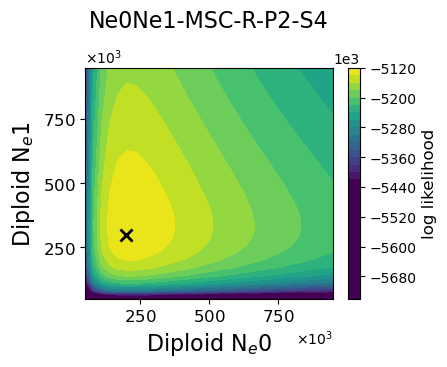

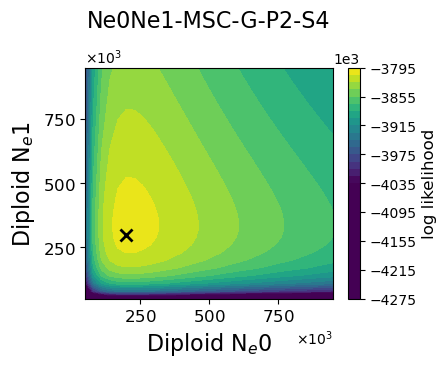

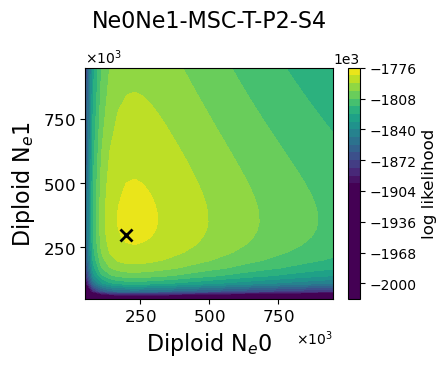

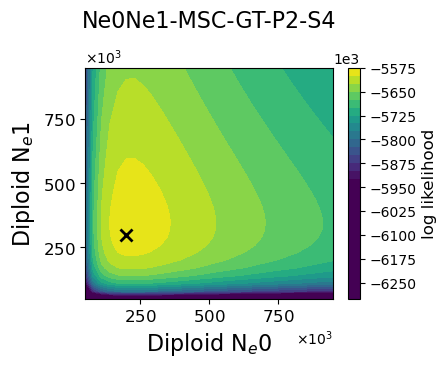

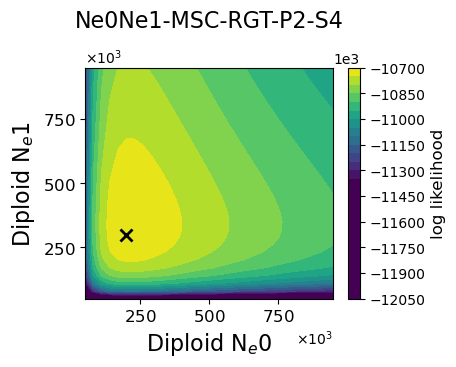

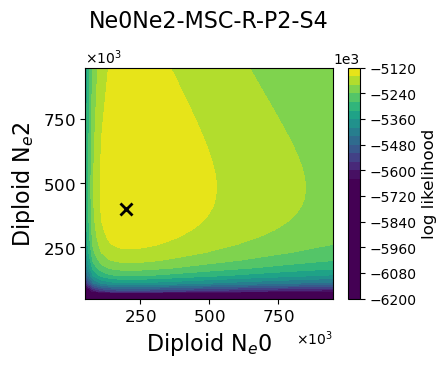

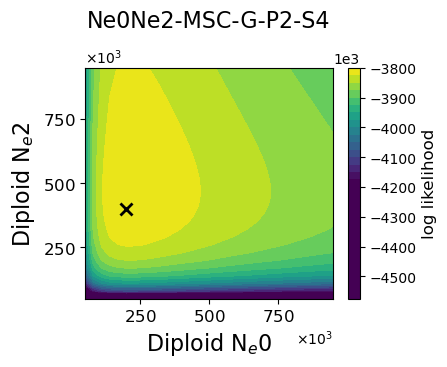

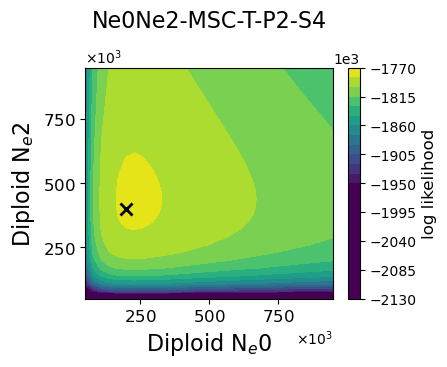

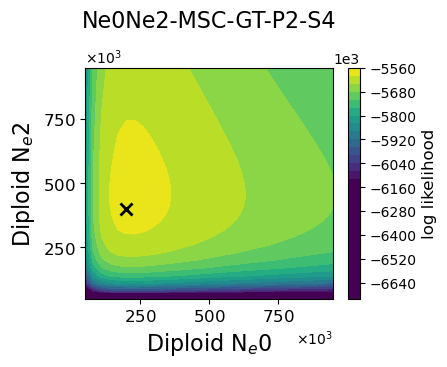

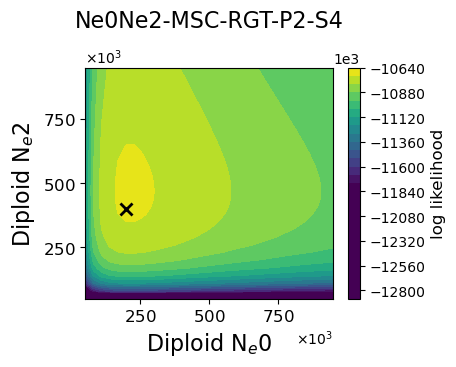

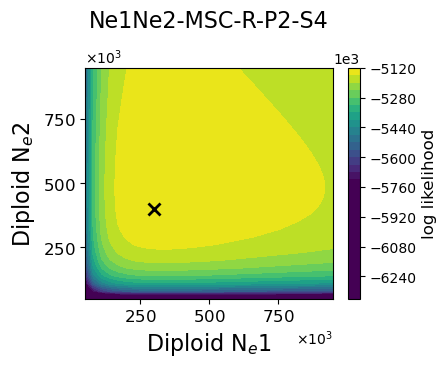

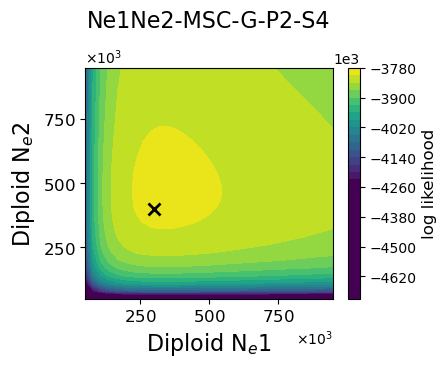

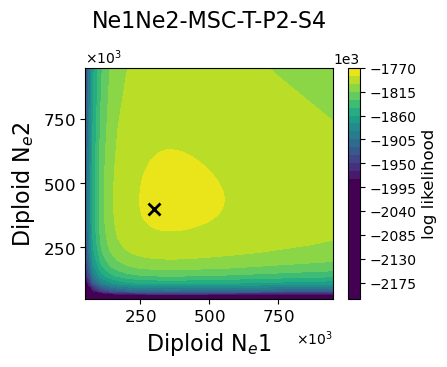

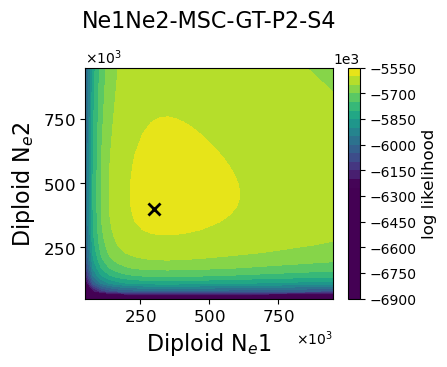

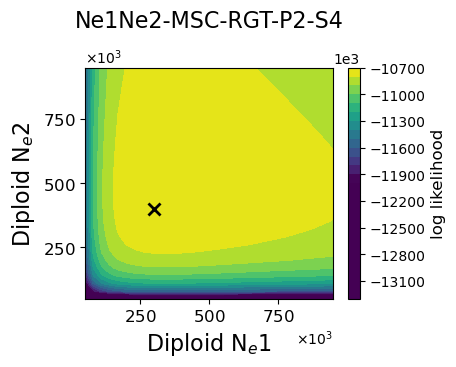

In [54]:
for nx, ny in [(0, 1), (0, 2), (1, 2)]:

    MSC_N_R = get_msc_likelihood_surface_Nx_Ny(
        R,
        nx, ny,
        min_neff=NEFF_MIN,
        max_neff=NEFF_MAX,
        n_values=N_VALUES,
    )
    
    MSC_N_G = get_msc_likelihood_surface_Nx_Ny(
        G,
        nx, ny,
        min_neff=NEFF_MIN,
        max_neff=NEFF_MAX,
        n_values=N_VALUES,
    )

    MSC_N_T = get_msc_likelihood_surface_Nx_Ny(
        T,
        nx, ny,
        min_neff=NEFF_MIN, 
        max_neff=NEFF_MAX,
        n_values=N_VALUES,
    )
    
    # store for later
    MSC[(nx, ny, 'r')] = MSC_N_R
    MSC[(nx, ny, 'g')] = MSC_N_G
    MSC[(nx, ny, 't')] = MSC_N_T
    MSC[(nx, ny, 'gt')] = MSC_N_G[0], MSC_N_G[1], MSC_N_G[2] + MSC_N_T[2]
    MSC[(nx, ny, 'rgt')] = MSC_N_G[0], MSC_N_G[1], MSC_N_R[2] + MSC_N_G[2] + MSC_N_T[2]

    # plot it
    title = f"Ne{nx}Ne{ny}-MSC-R-P{NSPECIES}-S{NSAMPLES}"
    c, a, m = plot_likelihood_surface_Nx_Ny(*MSC_N_R, nidx=nx, nidy=ny, title=title);
    c.savefig((DIR / title).with_suffix('.svg'))

    title = f"Ne{nx}Ne{ny}-MSC-G-P{NSPECIES}-S{NSAMPLES}"
    c, a, m = plot_likelihood_surface_Nx_Ny(*MSC_N_G, nidx=nx, nidy=ny, title=title);
    c.savefig((DIR / title).with_suffix('.svg'))

    title = f"Ne{nx}Ne{ny}-MSC-T-P{NSPECIES}-S{NSAMPLES}"
    c, a, m = plot_likelihood_surface_Nx_Ny(*MSC_N_T, nidx=nx, nidy=ny, title=title);
    c.savefig((DIR / title).with_suffix('.svg'))
    
    title = f"Ne{nx}Ne{ny}-MSC-GT-P{NSPECIES}-S{NSAMPLES}"
    c, a, m = plot_likelihood_surface_Nx_Ny(*MSC[(nx, ny, 'gt')], nidx=nx, nidy=ny, title=title);
    c.savefig((DIR / title).with_suffix('.svg'))

    title = f"Ne{nx}Ne{ny}-MSC-RGT-P{NSPECIES}-S{NSAMPLES}"
    c, a, m = plot_likelihood_surface_Nx_Ny(*MSC[(nx, ny, 'rgt')], nidx=nx, nidy=ny, title=title);
    c.savefig((DIR / title).with_suffix('.svg'))

#### MSC fit (r, Ne0) using tree-change or topo-change trees

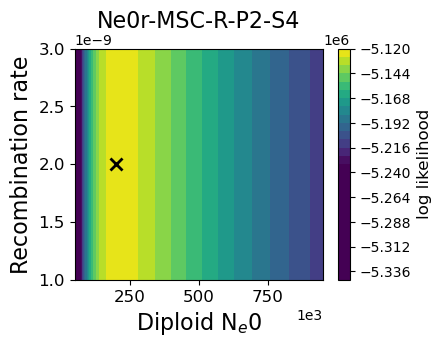

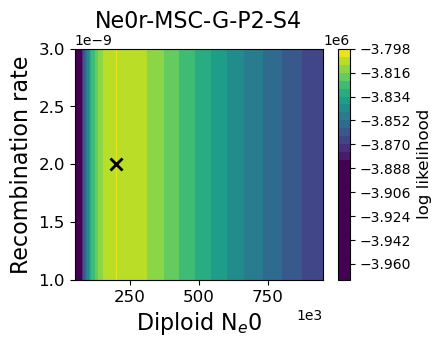

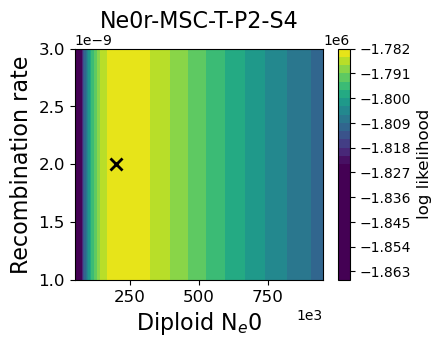

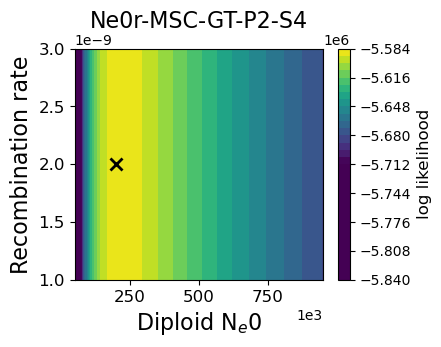

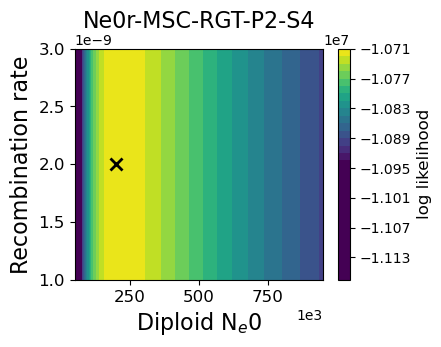

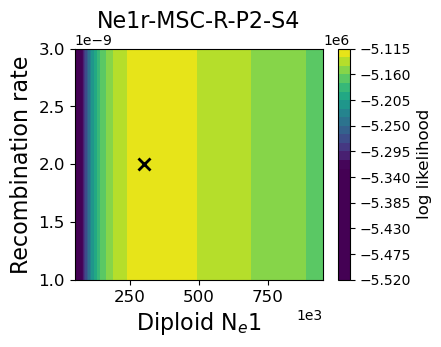

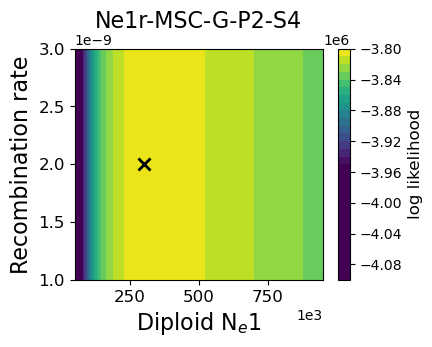

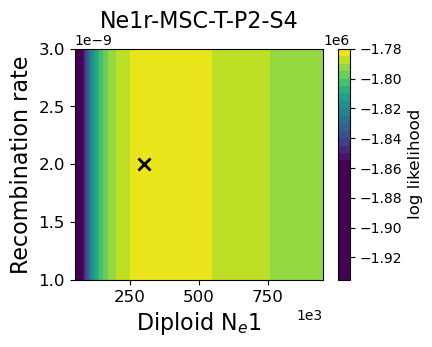

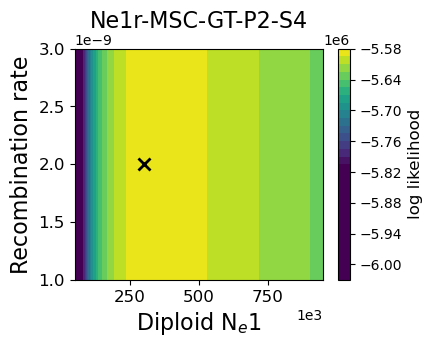

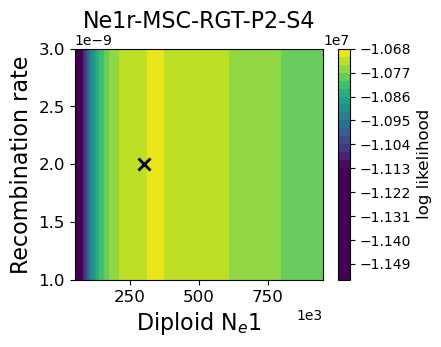

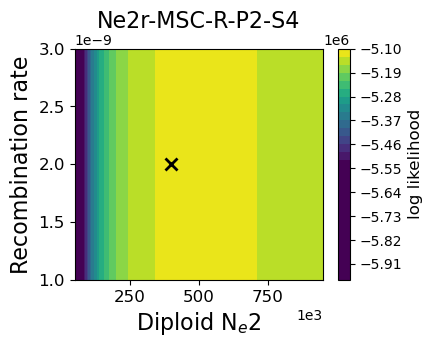

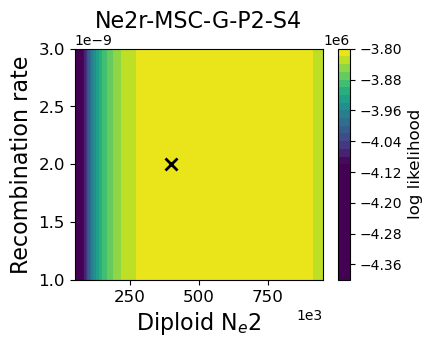

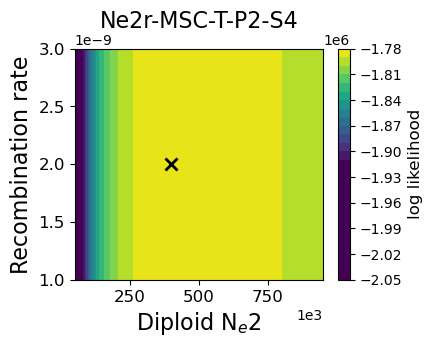

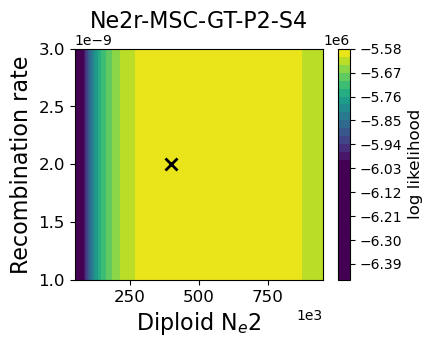

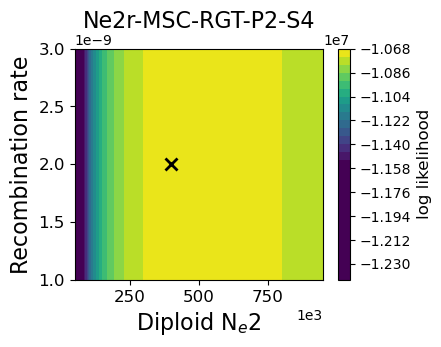

In [55]:
for nx in range(sptree.nnodes):

    MSC_r_R = get_msc_likelihood_surface_Nx_r(
        R,
        nidx=nx,
        min_neff=NEFF_MIN,
        max_neff=NEFF_MAX,
        min_recomb=R_MIN,
        max_recomb=R_MAX,
        n_values=N_VALUES,
    )
    
    MSC_r_G = get_msc_likelihood_surface_Nx_r(
        G,
        nidx=nx,
        min_neff=NEFF_MIN,
        max_neff=NEFF_MAX,
        min_recomb=R_MIN,
        max_recomb=R_MAX,
        n_values=N_VALUES,
    )

    MSC_r_T = get_msc_likelihood_surface_Nx_r(
        T,
        nidx=nx,
        min_neff=NEFF_MIN,
        max_neff=NEFF_MAX,
        min_recomb=R_MIN,
        max_recomb=R_MAX,
        n_values=N_VALUES,
    )
    
    # store for later
    MSC[(nx, 'r', 'r')] = MSC_r_R
    MSC[(nx, 'r', 'g')] = MSC_r_G
    MSC[(nx, 'r', 't')] = MSC_r_T
    MSC[(nx, 'r', 'gt')] = MSC_r_G[0], MSC_r_G[1], MSC_r_G[2] + MSC_r_T[2]
    MSC[(nx, 'r', 'rgt')] = MSC_r_G[0], MSC_r_G[1], MSC_r_R[2] + MSC_r_G[2] + MSC_r_T[2]

    # plot it
    title = f"Ne{nx}r-MSC-R-P{NSPECIES}-S{NSAMPLES}"
    c, _, _ = plot_likelihood_surface_r_Nx(*MSC_r_R, nidx=nx, title=title);
    c.savefig((DIR / title).with_suffix('.svg'))

    title = f"Ne{nx}r-MSC-G-P{NSPECIES}-S{NSAMPLES}"
    c, _, _ = plot_likelihood_surface_r_Nx(*MSC_r_G, nidx=nx, title=title);
    c.savefig((DIR / title).with_suffix('.svg'))

    title = f"Ne{nx}r-MSC-T-P{NSPECIES}-S{NSAMPLES}"
    c, _, _ = plot_likelihood_surface_r_Nx(*MSC_r_T, nidx=nx, title=title);
    c.savefig((DIR / title).with_suffix('.svg'))
    
    title = f"Ne{nx}r-MSC-GT-P{NSPECIES}-S{NSAMPLES}"
    c, _, _ = plot_likelihood_surface_r_Nx(*MSC[(nx, 'r', 'gt')], nidx=nx, title=title);
    c.savefig((DIR / title).with_suffix('.svg'))
    
    title = f"Ne{nx}r-MSC-RGT-P{NSPECIES}-S{NSAMPLES}"
    c, _, _ = plot_likelihood_surface_r_Nx(*MSC[(nx, 'r', 'rgt')], nidx=nx, title=title);
    c.savefig((DIR / title).with_suffix('.svg'))

#### SMC fit (Ne0, Ne1) using tree-change or topo-change trees and lengths

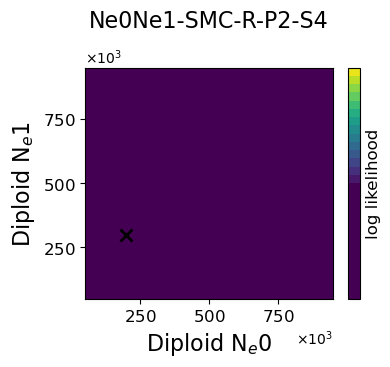

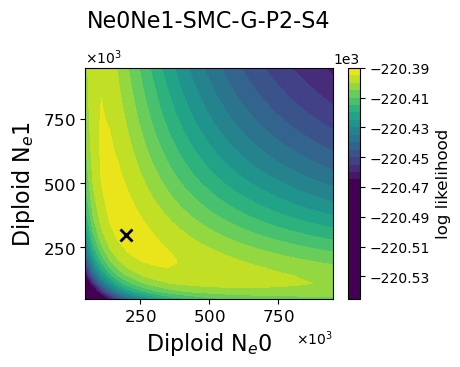

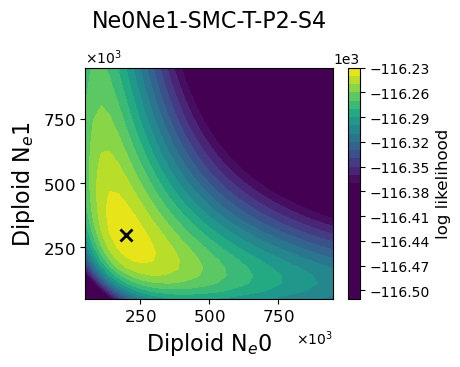

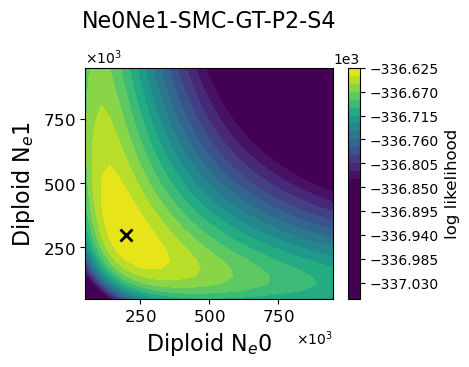

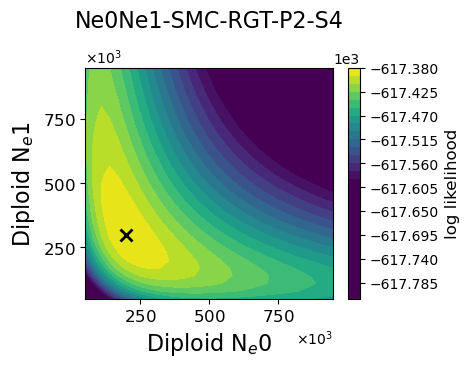

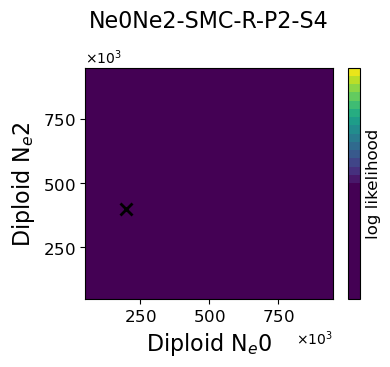

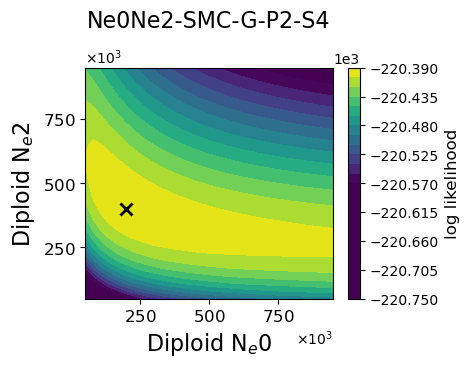

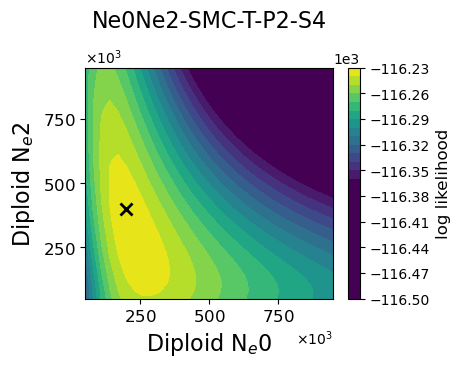

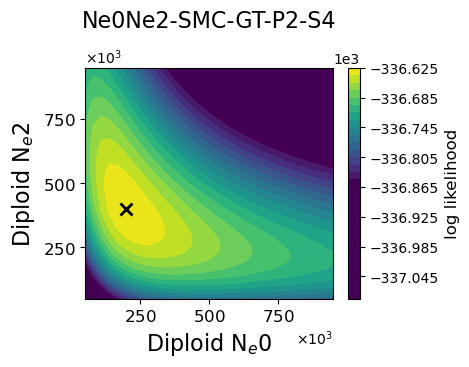

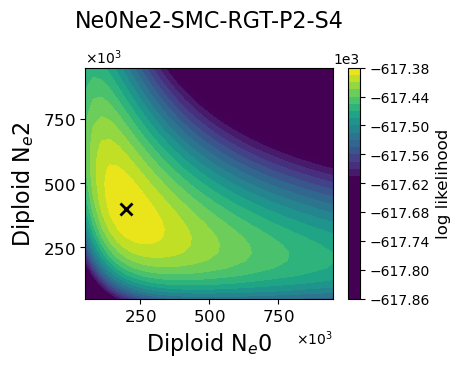

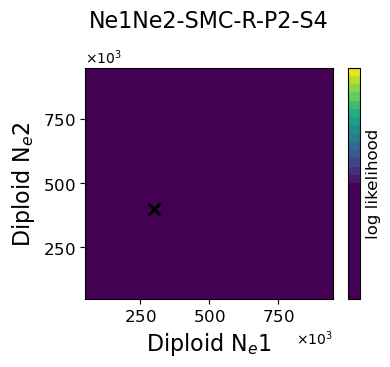

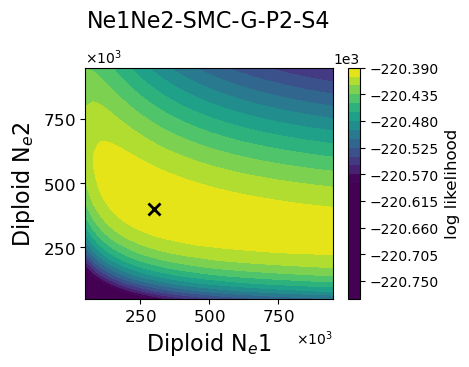

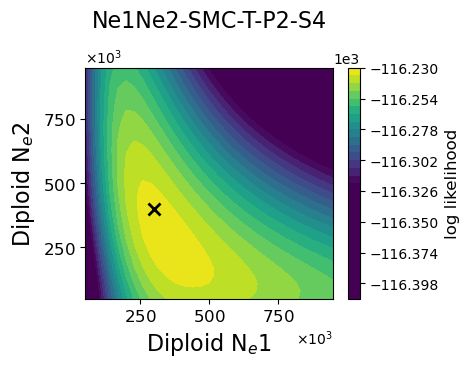

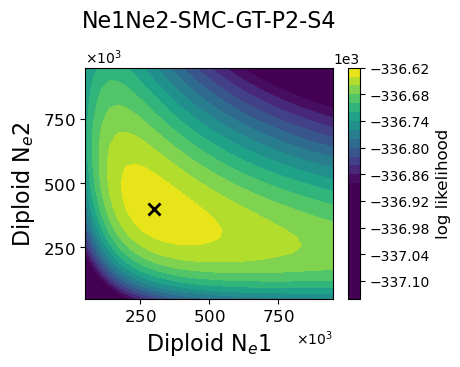

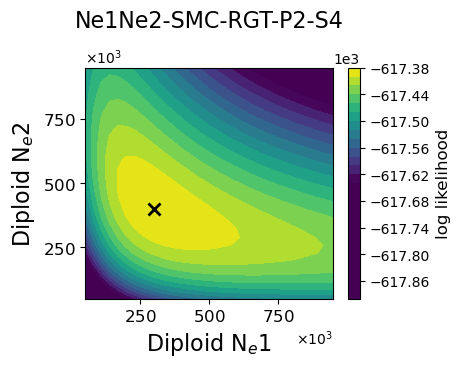

In [56]:
for nx, ny in [(0, 1), (0, 2), (1, 2)]:

    SMC_N_R = get_smc_likelihood_surface_Nx_Ny(
        R,
        dists_r,
        event_type=0,
        nidx=nx, nidy=ny,
        min_neff=NEFF_MIN, 
        max_neff=NEFF_MAX,
        n_values=N_VALUES,
    )
    
    SMC_N_G = get_smc_likelihood_surface_Nx_Ny(
        G,
        dists_g,
        event_type=1,
        nidx=nx, nidy=ny,
        min_neff=NEFF_MIN, 
        max_neff=NEFF_MAX,
        n_values=N_VALUES,
    )

    SMC_N_T = get_smc_likelihood_surface_Nx_Ny(
        T,
        dists_t,
        event_type=2,
        nidx=nx, nidy=ny,
        min_neff=NEFF_MIN, 
        max_neff=NEFF_MAX,
        n_values=N_VALUES,
    )
    
    # store for later
    SMC[(nx, ny, 'r')] = SMC_N_R  
    SMC[(nx, ny, 'g')] = SMC_N_G
    SMC[(nx, ny, 't')] = SMC_N_T
    SMC[(nx, ny, 'gt')] = SMC_N_G[0], SMC_N_G[1], SMC_N_G[2] + SMC_N_T[2]
    SMC[(nx, ny, 'rgt')] = SMC_N_G[0], SMC_N_G[1], SMC_N_R[2] + SMC_N_G[2] + SMC_N_T[2]
    
    # plot it    
    title = f"Ne{nx}Ne{ny}-SMC-R-P{NSPECIES}-S{NSAMPLES}"
    c, _, _ = plot_likelihood_surface_Nx_Ny(*SMC_N_R, nidx=nx, nidy=ny, title=title);
    c.savefig((DIR / title).with_suffix('.svg'))

    title = f"Ne{nx}Ne{ny}-SMC-G-P{NSPECIES}-S{NSAMPLES}"
    c, _, _ = plot_likelihood_surface_Nx_Ny(*SMC_N_G, nidx=nx, nidy=ny, title=title);
    c.savefig((DIR / title).with_suffix('.svg'))

    title = f"Ne{nx}Ne{ny}-SMC-T-P{NSPECIES}-S{NSAMPLES}"
    c, _, _ = plot_likelihood_surface_Nx_Ny(*SMC_N_T, nidx=nx, nidy=ny, title=title);
    c.savefig((DIR / title).with_suffix('.svg'))

    title = f"Ne{nx}Ne{ny}-SMC-GT-P{NSPECIES}-S{NSAMPLES}"
    c, _, _ = plot_likelihood_surface_Nx_Ny(*SMC[(nx, ny, 'gt')], nidx=nx, nidy=ny, title=title)
    c.savefig((DIR / title).with_suffix('.svg'))

    title = f"Ne{nx}Ne{ny}-SMC-RGT-P{NSPECIES}-S{NSAMPLES}"
    c, _, _ = plot_likelihood_surface_Nx_Ny(*SMC[(nx, ny, 'rgt')], nidx=nx, nidy=ny, title=title)
    c.savefig((DIR / title).with_suffix('.svg'))

#### SMC fit (r, Ne0) using tree-change or topo-change trees and lengths

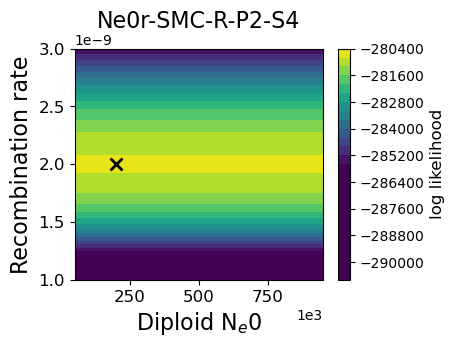

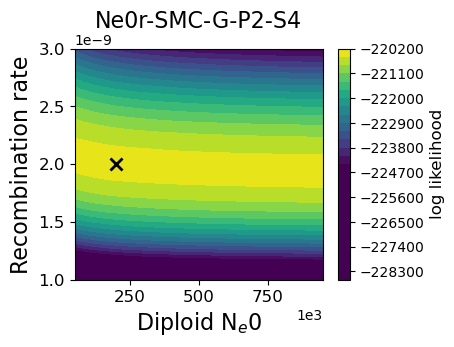

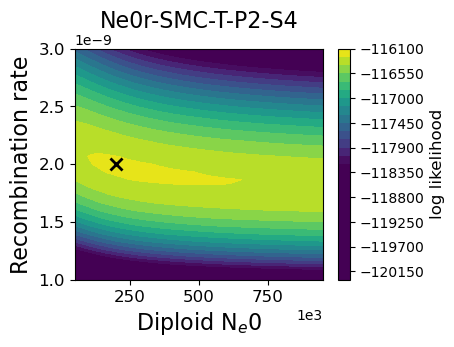

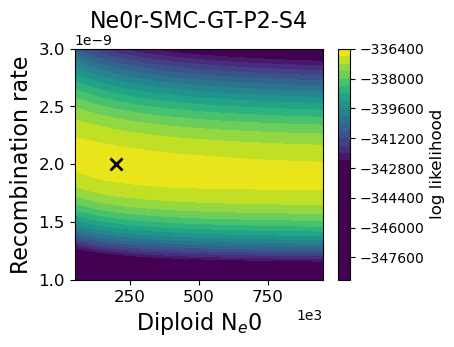

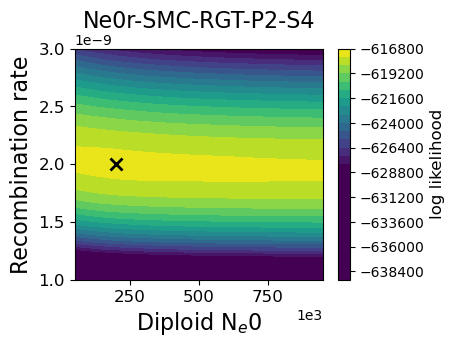

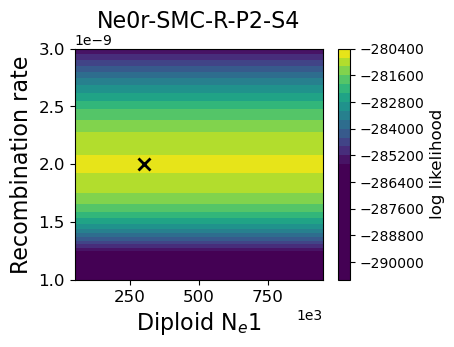

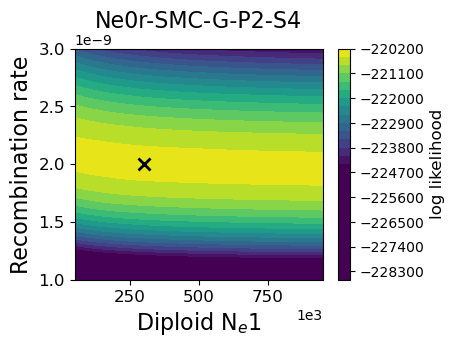

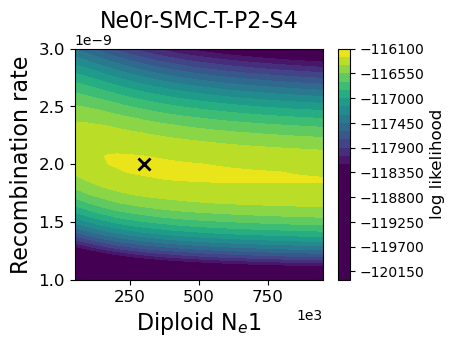

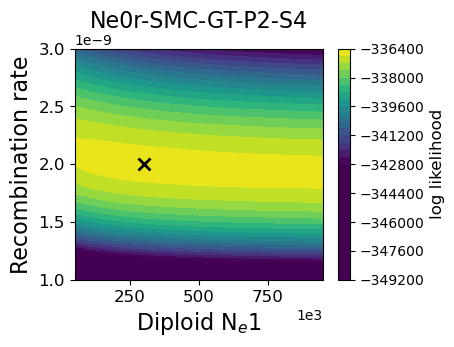

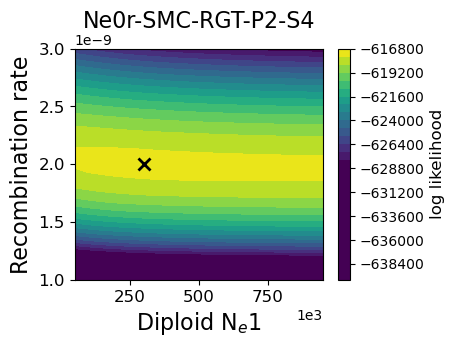

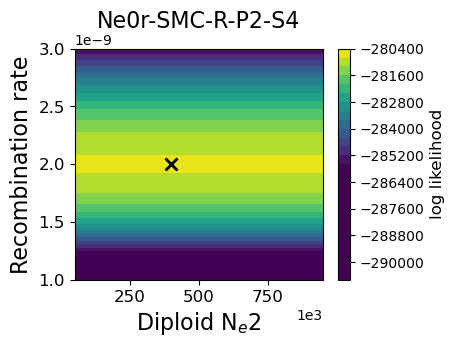

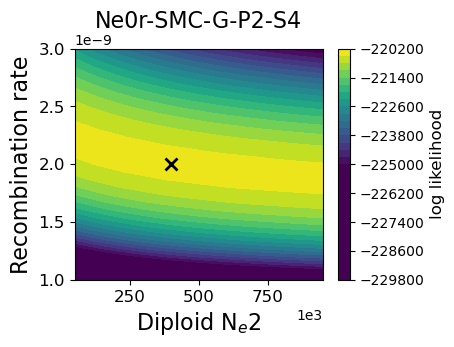

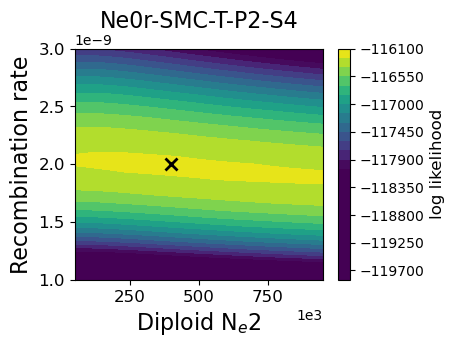

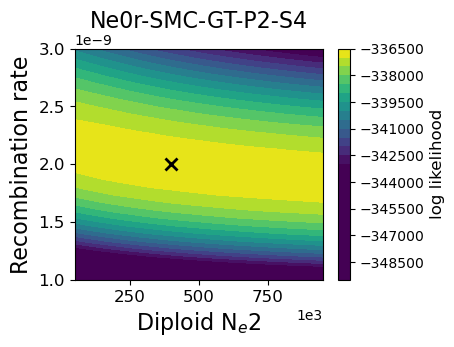

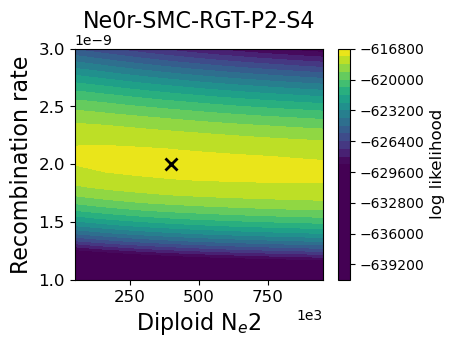

In [57]:
for nx in range(sptree.nnodes):

    SMC_r_R = get_smc_likelihood_surface_Nx_r(
        R,
        dists_r,
        event_type=0,
        nidx=nx,
        min_neff=NEFF_MIN, 
        max_neff=NEFF_MAX,
        min_recomb=R_MIN,
        max_recomb=R_MAX,
        n_values=N_VALUES,
    )
    
    SMC_r_G = get_smc_likelihood_surface_Nx_r(
        G,
        dists_g,
        event_type=1,
        nidx=nx,
        min_neff=NEFF_MIN, 
        max_neff=NEFF_MAX,
        min_recomb=R_MIN,
        max_recomb=R_MAX,
        n_values=N_VALUES,
    )

    SMC_r_T = get_smc_likelihood_surface_Nx_r(
        T,
        dists_t,
        event_type=2,
        nidx=nx,
        min_neff=NEFF_MIN, 
        max_neff=NEFF_MAX,
        min_recomb=R_MIN,
        max_recomb=R_MAX,
        n_values=N_VALUES,
    )
    
    # store for later
    SMC[(nx, 'r', 'r')] = SMC_r_R
    SMC[(nx, 'r', 'g')] = SMC_r_G
    SMC[(nx, 'r', 't')] = SMC_r_T
    SMC[(nx, 'r', 'gt')] = SMC_r_G[0], SMC_r_G[1], SMC_r_G[2] + SMC_r_T[2]
    SMC[(nx, 'r', 'rgt')] = SMC_r_G[0], SMC_r_G[1], SMC_r_R[2] + SMC_r_G[2] + SMC_r_T[2]

    title = f"Ne0r-SMC-R-P{NSPECIES}-S{NSAMPLES}"
    c, _, _ = plot_likelihood_surface_r_Nx(*SMC_r_R, nidx=nx, title=title);
    c.savefig((DIR / title).with_suffix('.svg'))

    title = f"Ne0r-SMC-G-P{NSPECIES}-S{NSAMPLES}"
    c, _, _ = plot_likelihood_surface_r_Nx(*SMC_r_G, nidx=nx, title=title);
    c.savefig((DIR / title).with_suffix('.svg'))

    title = f"Ne0r-SMC-T-P{NSPECIES}-S{NSAMPLES}"
    c, _, _ = plot_likelihood_surface_r_Nx(*SMC_r_T, nidx=nx, title=title);
    c.savefig((DIR / title).with_suffix('.svg'))

    title = f"Ne0r-SMC-GT-P{NSPECIES}-S{NSAMPLES}"
    c, _, _ = plot_likelihood_surface_r_Nx(*SMC[(nx, 'r', 'gt')], nidx=nx, title=title);
    c.savefig((DIR / title).with_suffix('.svg'))
    
    title = f"Ne0r-SMC-RGT-P{NSPECIES}-S{NSAMPLES}"
    c, _, _ = plot_likelihood_surface_r_Nx(*SMC[(nx, 'r', 'rgt')], nidx=nx, title=title);
    c.savefig((DIR / title).with_suffix('.svg'))

#### COMBINED

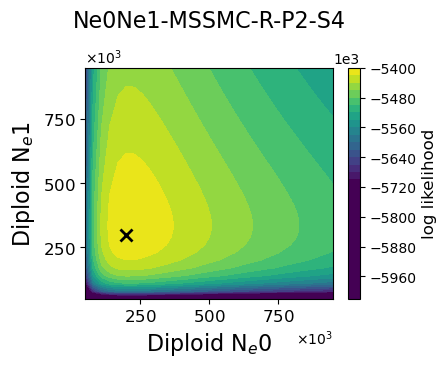

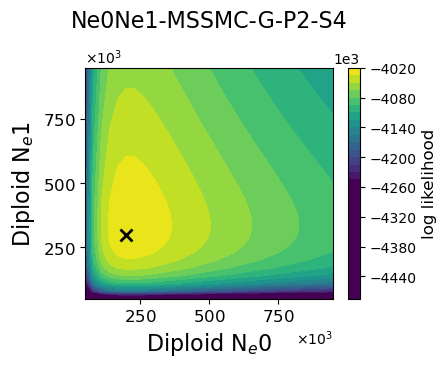

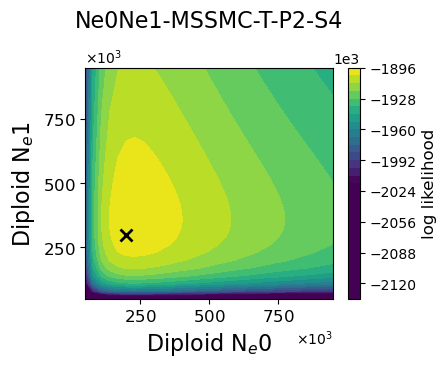

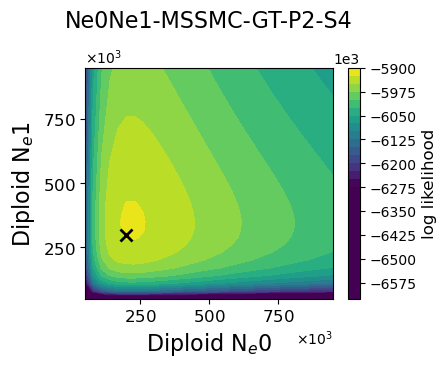

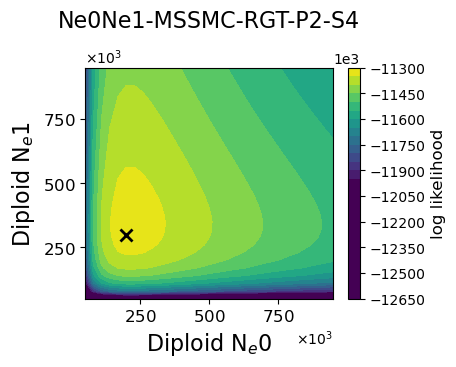

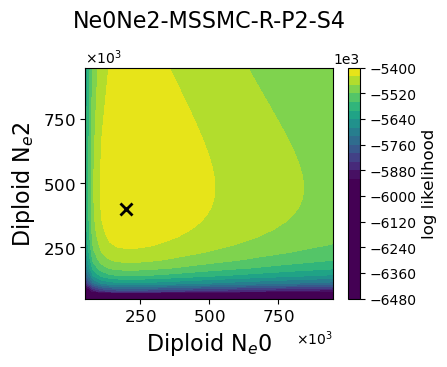

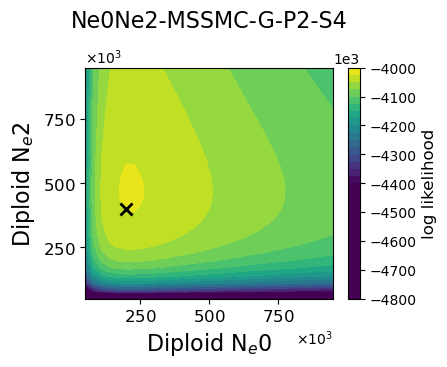

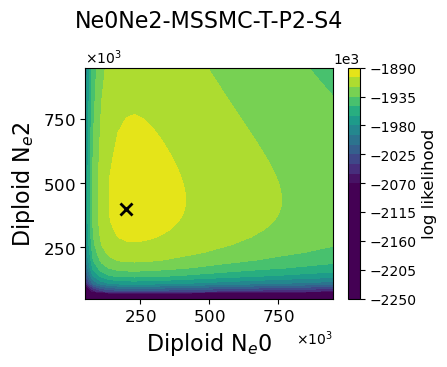

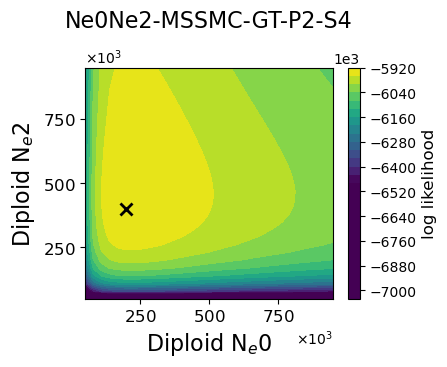

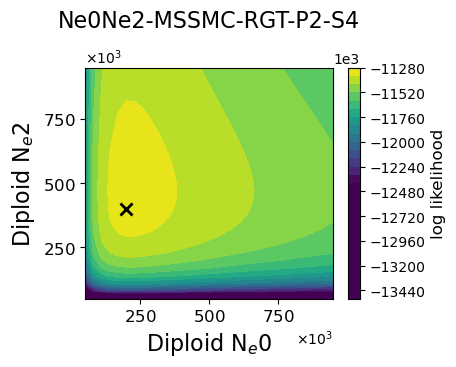

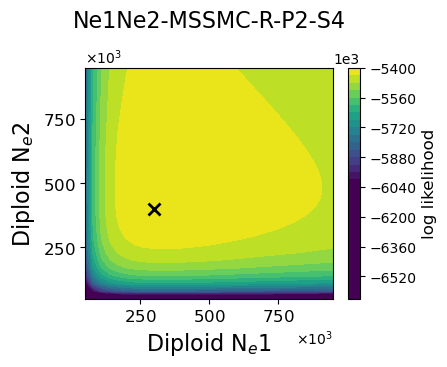

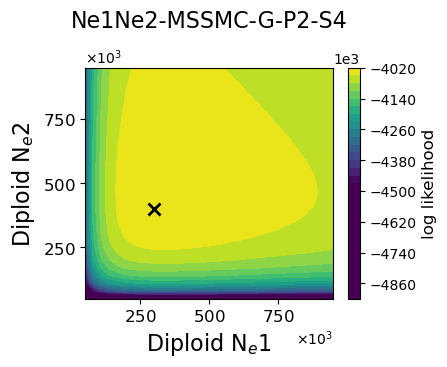

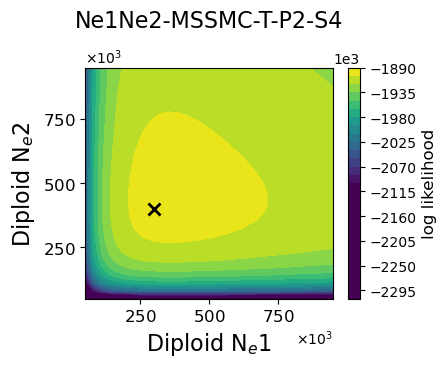

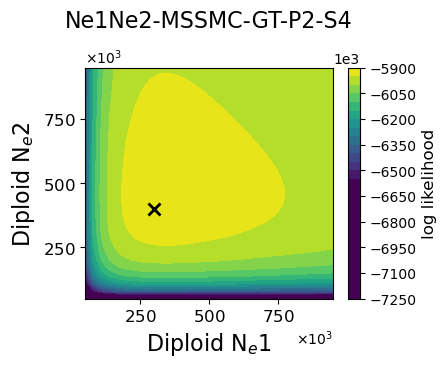

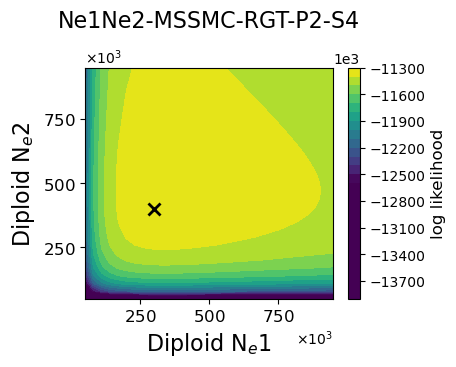

In [58]:
for nx, ny in [(0, 1), (0, 2), (1, 2)]:
    
    for e in ('r', 'g', 't', 'gt', 'rgt'):
        
        msc = MSC[(nx, ny, e)]
        smc = SMC[(nx, ny, e)]

        title = f"Ne{nx}Ne{ny}-MSSMC-{e.upper()}-P{NSPECIES}-S{NSAMPLES}"
        c, _, _ = plot_likelihood_surface_Nx_Ny(msc[0], msc[1], msc[2] + smc[2], nidx=nx, nidy=ny, title=title)
        c.savefig((DIR / title).with_suffix('.svg'))

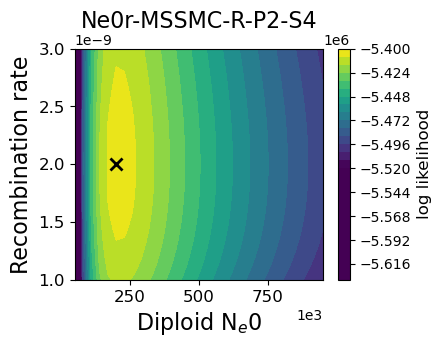

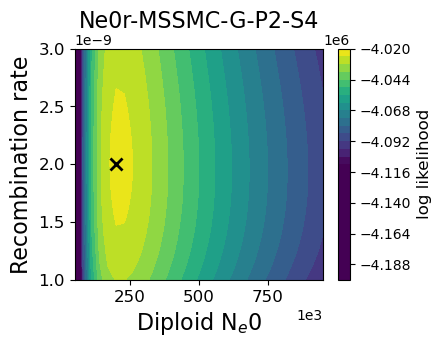

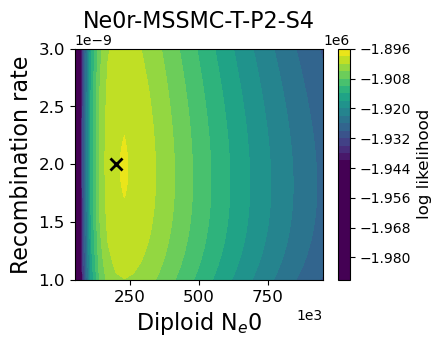

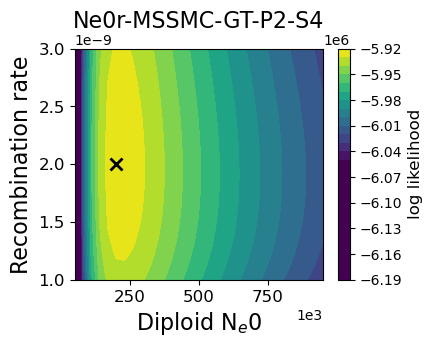

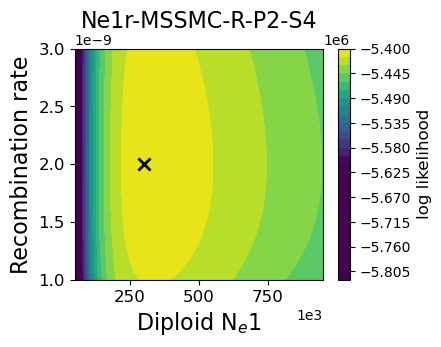

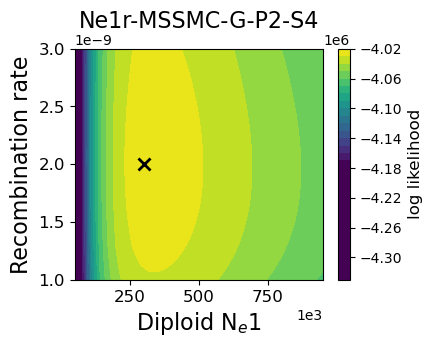

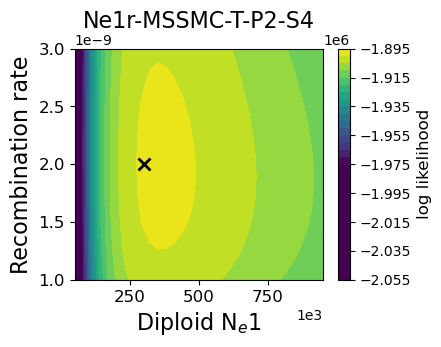

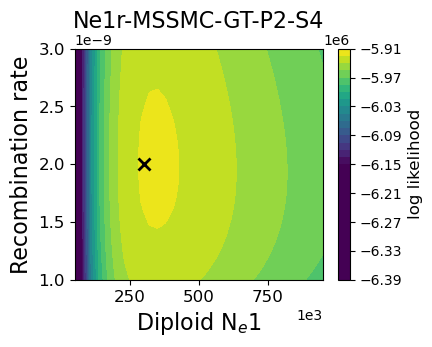

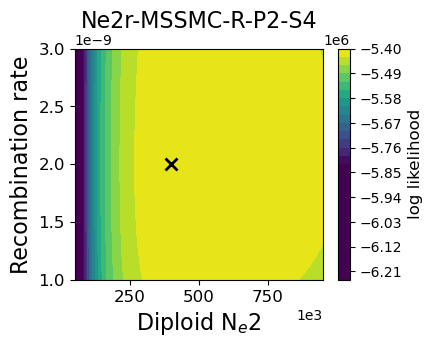

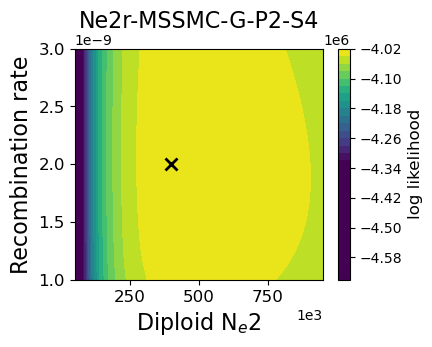

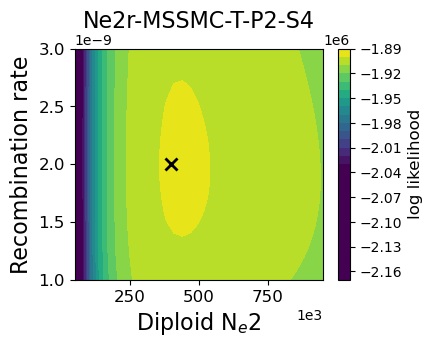

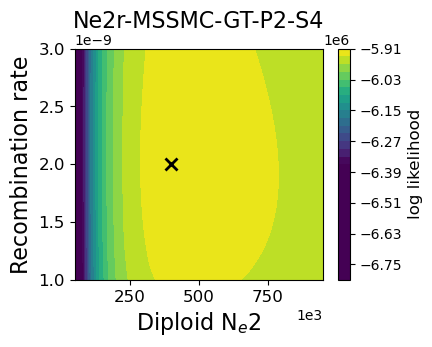

In [59]:
for nx in range(sptree.nnodes):
    
    for e in ('r', 'g', 't', 'gt'):
        
        msc = MSC[(nx, 'r', e)]
        smc = SMC[(nx, 'r', e)]

        title = f"Ne{nx}r-MSSMC-{e.upper()}-P{NSPECIES}-S{NSAMPLES}"
        c, _, _ = plot_likelihood_surface_r_Nx(msc[0], msc[1], msc[2] + smc[2], nidx=nx, title=title);
        c.savefig((DIR / title).with_suffix('.svg'))